# PTC

Contact author: Alex Broughton


## Introduction

Goals:
- Inspect PTC
- Test pipeline configurations
- Measure sensor parameters

## 1.0 Set Up

In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep ip_isr
! eups list -s | grep cp_pipe

lsst_distrib          g4213664e8e+0dcb05a918 	w_2023_47 setup
ip_isr                LOCAL:/sdf/home/a/abrought/alternate_branches/current/ip_isr 	setup
cp_pipe               LOCAL:/sdf/home/a/abrought/alternate_branches/current/cp_pipe 	setup


In [2]:
### Import packages:
from lsst.daf.butler import Butler
from lsst.obs.lsst import LsstCam
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import numpy as numpy
from lsst.ip.isr.isrTask import IsrTask

matplotlib.rcParams.update({'font.size': 13})
plt.style.use('tableau-colorblind10')

# Set up some plotting defaults:

params = {'axes.labelsize': 13,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.major.width': 1.5,
          'xtick.minor.width': 1,
          'xtick.major.size': 6,
          'xtick.minor.size': 3,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 1.5,
          'axes.linewidth': 1.5,
          'axes.labelweight': 1.5,
          'axes.titleweight': 1.5,
          'ytick.major.width': 1.5,
          'ytick.minor.width': 1,
          'ytick.major.size': 6,
          'ytick.minor.size': 3,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [3]:
# Useful functions

def chi2_ndof(ptc, AMP):
        """
        returns the array of chi2/ndof contributions indexed by i and j for single AMP
    
        """
        gain = ptc.gain[AMP]
        n = ptc.noiseMatrix[AMP][0][0]
        if np.isnan(n):
            n = ptc.noise[AMP]

        expIdMask = ptc.expIdMask[AMP]
        mask_extended = (ptc.rawMeans[AMP]*gain > 0.2e5) * (ptc.rawMeans[AMP]*gain < .6e5)                              
        mask = expIdMask * mask_extended

        data = (ptc.covariances[AMP][mask] - n/gain**2) * (gain**2)
        model = (ptc.covariancesModel[AMP][mask] - n/gain**2) * (gain**2)
        w = (ptc.covariancesSqrtWeights[AMP][mask] / gain)**2
        
        if model.shape != data.shape:
            data=data[:,:model.shape[1],:model.shape[2]]
            w=w[:,:model.shape[1],:model.shape[2]]

        mask = w != 0
        ndof = mask.sum(axis=0)-2
        # for 0,0, count-3 is more accurate:
        ndof[0,0] -= 1

        for i in range(ndof.shape[0]):
            for j in range(ndof.shape[1]):
                if not i==0 and not j==0:
                    ndof[i][j] *= 2

        chi2_ndof = (((model-data)**2)*w).sum(axis=0)/ndof
        
        return chi2_ndof
    
def cov_direct_value(diff ,w, dx,dy):
    (ncols,nrows) = diff.shape
    if dy>=0 :
        im1 = diff[dy:, dx:]
        w1 = w[dy:, dx:]
        im2 = diff[:ncols-dy, :nrows-dx]
        w2=w[:ncols-dy, :nrows-dx]
    else:
        im1 = diff[:ncols+dy, dx:]
        w1 = w[:ncols+dy, dx:]
        im2 = diff[-dy:, :nrows-dx]
        w2 = w[-dy:, :nrows-dx]
    w_all = w1*w2
    npix = w_all.sum()
    im1_times_w = im1*w_all
    s1 = im1_times_w.sum()/npix
    s2 = (im2*w_all).sum()/npix
    p = (im1_times_w*im2).sum()/npix
    cov = p-s1*s2
    return cov,npix

def compute_cov(diff, w, fft_shape, maxrange) :
    """
    diff : image to compute the covariance of
    w : weights (0 or 1) of the pixels of diff
    fft_shape : the actual shape of the DFTs
    maxrange: last index of the covariance to be computed
    returns cov[maxrange, maxrange], npix[maxrange,maxrange]
    """
    assert(fft_shape[0]>diff.shape[0]+maxrange)
    assert(fft_shape[1]>diff.shape[1]+maxrange)
    # for some reason related to numpy.fft.rfftn,
    # the second dimension should be even, so
    my_fft_shape = fft_shape
    if fft_shape[1] %2 == 1 :
        my_fft_shape = (fft_shape[0], fft_shape[1]+1)
    # FFT of the image
    tim = np.fft.rfft2(diff*w, my_fft_shape)
    # FFT of the mask
    tmask = np.fft.rfft2(w, my_fft_shape)
    # three inverse transforms:
    pcov = np.fft.irfft2(tim*tim.conjugate())
    pmean= np.fft.irfft2(tim*tmask.conjugate())
    pcount= np.fft.irfft2(tmask*tmask.conjugate())
    # now evaluate covariances and numbers of "active" pixels
    cov = np.ndarray((maxrange,maxrange))
    npix = np.zeros_like(cov)
    for dx in range(maxrange) :
        for dy in range(maxrange) :
            # compensate rounding errors
            npix1 = int(round(pcount[dy,dx]))
            cov1 = pcov[dy,dx]/npix1-pmean[dy,dx]*pmean[-dy,-dx]/(npix1*npix1)
            if (dx == 0 or dy == 0):
                cov[dy,dx] = cov1
                npix[dy,dx] = npix1
                continue
            npix2 = int(round(pcount[-dy,dx]))
            cov2 = pcov[-dy,dx]/npix2-pmean[-dy,dx]*pmean[dy,-dx]/(npix2*npix2)
            cov[dy,dx] = 0.5*(cov1+cov2)
            npix[dy,dx] = npix1+npix2
    return cov,npix


def measureMeanVarCov(f1, f2):
    """Calculate the mean of each of two exposures and the variance
    and covariance of their difference. The variance is calculated
    via afwMath, and the covariance via the methods in Astier+19
    (appendix A). In theory, var = covariance[0,0]. This should
    be validated, and in the future, we may decide to just keep
    one (covariance).

    Parameters
    ----------
    im1Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 1.
    im2Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 2.
    imStatsCtrl : `lsst.afw.math.StatisticsControl`
        Statistics control object.
    mu1: `float`
        Clipped mean of im1Area (ADU).
    mu2: `float`
        Clipped mean of im2Area (ADU).

    Returns
    -------
    mu : `float` or `NaN`
        0.5*(mu1 + mu2), where mu1, and mu2 are the clipped means
        of the regions in both exposures. If either mu1 or m2 are
        NaN's, the returned value is NaN.
    varDiff : `float` or `NaN`
        Half of the clipped variance of the difference of the
        regions inthe two input exposures. If either mu1 or m2 are
        NaN's, the returned value is NaN.
    covDiffAstier : `list` or `NaN`
        List with tuples of the form (dx, dy, var, cov, npix), where:
            dx : `int`
                Lag in x
            dy : `int`
                Lag in y
            var : `float`
                Variance at (dx, dy).
            cov : `float`
                Covariance at (dx, dy).
            nPix : `int`
                Number of pixel pairs used to evaluate var and cov.

        If either mu1 or m2 are NaN's, the returned value is NaN.
    """
    
    #h1 = fits.open(f1)
    #h2 = fits.open(f2)
    mu1 = np.mean(f1.image.array)
    mu2 = np.mean(f2.image.array)
    mu = 0.5*(mu1 + mu2)
    #h1.close()
    #h2.close()
    
    import lsst.afw.math as afwMath
    #from lsst.afw.image.maskedImage import MaskedImageF
    from lsst.cp.pipe.utils import (arrangeFlatsByExpTime, arrangeFlatsByExpId,
                                arrangeFlatsByExpFlux, sigmaClipCorrection,
                                CovFastFourierTransform)
    
    # Take difference of pairs
    # symmetric formula: diff = (mu2*im1-mu1*im2)/(0.5*(mu1+mu2))
    
    im1Area = f1.getMaskedImage()
    im2Area = f2.getMaskedImage()
    
    temp = im2Area.clone()
    temp *= mu1
    diffIm = im1Area.clone()
    diffIm *= mu2
    diffIm -= temp
    diffIm /= mu
    
    imMaskVal = im1Area.getMask().getPlaneBitMask(['SUSPECT', 'BAD', 'NO_DATA', 'SAT'])
    imStatsCtrl = afwMath.StatisticsControl(5.5, 3, imMaskVal)

    # Variance calculation via afwMath
    varDiff = 0.5*(afwMath.makeStatistics(diffIm, afwMath.VARIANCECLIP, imStatsCtrl).getValue())
    
    # Covariances calculations
    # Get the pixels that were not clipped
    varClip = afwMath.makeStatistics(diffIm, afwMath.VARIANCECLIP, imStatsCtrl).getValue()
    meanClip = afwMath.makeStatistics(diffIm, afwMath.MEANCLIP, imStatsCtrl).getValue()
    cut = meanClip + 5.5*np.sqrt(varClip)
    unmasked = np.where(np.fabs(diffIm.image.array) <= cut, 1, 0)

    # Get the pixels in the mask planes of the difference image
    # that were ignored by the clipping algorithm
    wDiff = np.where(diffIm.getMask().getArray() == 0, 1, 0)
    # Combine the two sets of pixels ('1': use; '0': don't use)
    # into a final weight matrix to be used in the covariance
    # calculations below.
    w = unmasked*wDiff

    maxRangeCov = 8

    # Calculate covariances via FFT.
    shapeDiff = np.array(diffIm.image.array.shape)
    # Calculate the sizes of FFT dimensions.
    s = shapeDiff + maxRangeCov
    tempSize = np.array(np.log(s)/np.log(2.)).astype(int)
    fftSize = np.array(2**(tempSize+1)).astype(int)
    fftShape = (fftSize[0], fftSize[1])
    c = CovFastFourierTransform(diffIm.image.array, w, fftShape, maxRangeCov)

    # np.sum(w) is the same as npix[0][0] returned in covDiffAstier
    try:
        covDiffAstier = c.reportCovFastFourierTransform(maxRangeCov)
    except ValueError:
        # This is raised if there are not enough pixels.
        print("Not enough pixels covering the requested covariance range in x/y (%d)", 8)
        return np.nan, np.nan, None

    # Compare Cov[0,0] and afwMath.VARIANCECLIP covDiffAstier[0]
    # is the Cov[0,0] element, [3] is the variance, and there's a
    # factor of 0.5 difference with afwMath.VARIANCECLIP.
    thresholdPercentage = 1
    fractionalDiff = 100*np.fabs(1 - varDiff/(covDiffAstier[0][3]*0.5))
    if fractionalDiff >= thresholdPercentage:
        print("Absolute fractional difference between afwMatch.VARIANCECLIP and Cov[0,0] "
                         "is more than %f%%: %f", thresholdPercentage, fractionalDiff)

    return mu, varDiff, covDiffAstier

def makeCovArray(inputTuple, maxRangeFromTuple=8):
        """Make covariances array from tuple.

        Parameters
        ----------
        inputTuple : `numpy.ndarray`
            Structured array with rows with at least
            (mu, afwVar, cov, var, i, j, npix), where:
            mu : `float`
                0.5*(m1 + m2), where mu1 is the mean value of flat1
                and mu2 is the mean value of flat2.
            afwVar : `float`
                Variance of difference flat, calculated with afw.
            cov : `float`
                Covariance value at lag(i, j)
            var : `float`
                Variance(covariance value at lag(0, 0))
            i : `int`
                Lag in dimension "x".
            j : `int`
                Lag in dimension "y".
            npix : `int`
                Number of pixels used for covariance calculation.
        maxRangeFromTuple : `int`
            Maximum range to select from tuple.

        Returns
        -------
        cov : `numpy.array`
            Covariance arrays, indexed by mean signal mu.
        vCov : `numpy.array`
            Variance of the [co]variance arrays, indexed by mean signal mu.
        muVals : `numpy.array`
            List of mean signal values.
        """
        if maxRangeFromTuple is not None:
            cut = (inputTuple['i'] < maxRangeFromTuple) & (inputTuple['j'] < maxRangeFromTuple)
            cutTuple = inputTuple[cut]
        else:
            cutTuple = inputTuple
        # increasing mu order, so that we can group measurements with the
        # same mu
        muTemp = cutTuple['mu']
        ind = np.argsort(muTemp)

        cutTuple = cutTuple[ind]
        # should group measurements on the same image pairs(same average)
        mu = cutTuple['mu']
        xx = np.hstack(([mu[0]], mu))
        delta = xx[1:] - xx[:-1]
        steps, = np.where(delta > 0)
        ind = np.zeros_like(mu, dtype=int)
        ind[steps] = 1
        ind = np.cumsum(ind)  # this acts as an image pair index.
        # now fill the 3-d cov array(and variance)
        muVals = np.array(np.unique(mu))
        i = cutTuple['i'].astype(int)
        j = cutTuple['j'].astype(int)
        c = 0.5*cutTuple['cov']
        n = cutTuple['npix']
        v = 0.5*cutTuple['var']
        # book and fill
        cov = np.ndarray((len(muVals), np.max(i)+1, np.max(j)+1))
        var = np.zeros_like(cov)
        cov[ind, i, j] = c
        var[ind, i, j] = v**2/n
        var[:, 0, 0] *= 2  # var(v) = 2*v**2/N

        return cov, var, muVals

def getCovArray(muDiff, varDiff, covAstier):
    # Turn the tuples with the measured information
    # into covariance arrays.
    # covrow: (i, j, var (cov[0,0]), cov, npix)
    
    tags = [('mu', '<f8'), ('afwVar', '<f8'), ('cov', '<f8'), ('var', '<f8'), ('i', '<i8'), ('j', '<i8'), ('npix', '<i8')]
    
    tupleRows = [(mu, varDiff, c, v, i, j, n) for (i,j,v,c,n) in covAstier]
    tempStructArray = np.array(tupleRows, dtype=tags)

    covArray, vcov, _ = makeCovArray(tempStructArray)
    covSqrtWeights = np.nan_to_num(1./np.sqrt(vcov))
    
    return covArray[0], covSqrtWeights[0]

def fit_chi2_ndof(mus,data, model,covSqrtWeights):
    """
    returns the array of chi2/ndof contributions indexed by i and j 
    """

    #w = np.ones(ptc.covariancesSqrtWeights[amp][mask3].shape)
    mask_exps = (mus > 10000.)
    w = (covSqrtWeights[mask_exps])**2
    mask = (w != 0)
    ndof = mask.sum(axis=0)-2
    # for 0,0, count-3 is more accurate:
    ndof[0,0] -= 1
    for i in range(ndof.shape[0]):
        for j in range(ndof.shape[1]):
            if not i==0 and not j==0:
                ndof[i][j] *= 2

    chi2_ndof = (((model[mask_exps]-data[mask_exps])**2)*w).sum(axis=0)/ndof

    chi2_ndof[np.isnan(chi2_ndof)] = -0.1

    return chi2_ndof

def getC(flat1,flat2):
    camera = LsstCam.getCamera()
    detector = camera.get(23)
    amps = detector.getAmplifiers()
    ampNames = [_.getName() for _ in amps]
    amp = amps[ampNames=="C00"]
    ampRegion = amp.getBBox().erodedBy(10)
    
    flat1_ = flat1.exposure.getCutout(ampRegion)
    flat2_ = flat2.exposure.getCutout(ampRegion)
    
    mu, varDiff, covDiffAstier = measureMeanVarCov(flat1_, flat2_)
    #C,covSqrtWeights = getCovArray(mu, varDiff, covDiffAstier)
    
    return mu, varDiff, covDiffAstier


def tileArray(in_array):
        """Given an input quarter-image, tile/mirror it and return full image.

        Given a square input of side-length n, of the form

        input = array([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]])

        return an array of size 2n-1 as

        output = array([[ 9,  8,  7,  8,  9],
                        [ 6,  5,  4,  5,  6],
                        [ 3,  2,  1,  2,  3],
                        [ 6,  5,  4,  5,  6],
                        [ 9,  8,  7,  8,  9]])

        Parameters
        ----------
        input : `np.array`, (N, N)
            The square input quarter-array

        Returns
        -------
        output : `np.array`, (2*N + 1, 2*N + 1)
            The full, tiled array
        """
        assert(in_array.shape[0] == in_array.shape[1])
        length = in_array.shape[0] - 1
        output = np.zeros((2*length + 1, 2*length + 1))

        for i in range(length + 1):
            for j in range(length + 1):
                output[i + length, j + length] = in_array[i, j]
                output[-i + length, j + length] = in_array[i, j]
                output[i + length, -j + length] = in_array[i, j]
                output[-i + length, -j + length] = in_array[i, j]
        return output

def bin_along_x(x, y, nbins, range_x):
    from scipy.stats import binned_statistic
    d, edges, _ = binned_statistic(x,y, statistic='mean', bins=nbins, range=range_x)
    return 0.5 * (edges[1:] + edges[:-1]), d

def astier19_eqn16(mu, a00,g,n_00sqd):
    n00 = n_00sqd
    return (1. / 2.*(g**2)) * (np.exp(2*a00*mu*g) - 1) + n00/g**2

def getPTCData(ptc, AMP):
    mu = ptc.rawMeans[AMP]
    g = ptc.gain[AMP]
    expIdMask = ptc.expIdMask[AMP]
    c00 = ptc.rawVars[AMP]
    c = ptc.covariances[AMP]
    c00_model = ptc.covariancesModel[AMP][:,0,0]
    n = ptc.noise[AMP]
    n_mat = ptc.noiseMatrix[AMP]
    a = ptc.aMatrix[AMP]

    c = c[:,:15,:15]
    
    r = (c00 / mu**2) - (mu/g + n/g**2)/(mu**2)
    r_model = (c00_model / mu**2) - (mu/g + n/g**2)/(mu**2)

    r_mat = np.zeros_like(c)
    for i,mu_ in enumerate(mu):
        r_mat[i] = (c[i] / mu_**2) - (n_mat/g**2)/(mu_**2)
        r_mat[i][0][0] = (c[i][0][0] / mu_**2) - (mu_/g + n_mat[0][0]/g**2)/(mu_**2)
    
    return mu, g, expIdMask, c00, c00_model, n, a, r, r_model, r_mat

def getPTCDataFromFits(f, AMP):
    from astropy.io import fits
    h = fits.open(f)
    
    mu = h[1].data['RAW_MEANS'][0]
    g = h[1].data['GAIN'][0]
    expIdMask = h[1].data['EXP_ID_MASK'][0]
    c00 = h[1].data['RAW_VARS'][0]
    try:
        c = h[1].data['COVARIANCES'][0].reshape((len(mu),40,40))
    except:
        c = h[1].data['COVARIANCES'][0].reshape((len(mu),15,15))
    c = c[:,:15,:15]
    c00_model = h[1].data['COVARIANCES_MODEL'][0].reshape((len(mu),15,15))[:,0,0]
    n = h[1].data['NOISE_MATRIX'][0].reshape((15,15))[0,0]
    n_mat = h[1].data['NOISE_MATRIX'][0].reshape((15,15))
    a = h[1].data['A_MATRIX'][0].reshape((15,15))[0,0]
    
    r = (c00 / mu**2) - (mu/g + n/g**2)/(mu**2)
    r_model = (c00_model / mu**2) - (mu/g + n/g**2)/(mu**2)

    r_mat = np.zeros_like(c)
    for i,mu_ in enumerate(mu):
        r_mat[i] = (c[i] / mu_**2) - (n_mat/g**2)/(mu_**2)
        r_mat[i][0][0] = (c[i][0][0] / mu_**2) - (mu_/g + n_mat[0][0]/g**2)/(mu_**2)

    return mu, g, expIdMask, c00, c00_model, n, a, r, r_model, r_mat

## Setup butler

In [4]:
butler = Butler("/repo/ir2")
registry = butler.registry

butlermain = Butler("/repo/main")
registrymain = butlermain.registry
registry.refresh()

## 2.0 Plotting $C_{00}$

In [15]:
ptc =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13539')

AMP="C00"
mu = ptc.rawMeans[AMP]
g = ptc.gain[AMP]
expIdMask = ptc.expIdMask[AMP]
c00 = ptc.rawVars[AMP]
c00_model = ptc.covariancesModel[AMP][:,0,0]
expmask = ptc.expIdMask[AMP]
n = ptc.noiseMatrix[AMP][0,0]
a = ptc.aMatrix[AMP]

r = (c00 / mu**2) - (mu/g + n/g**2)/(mu**2)
r_model = (c00_model / mu**2) - (mu/g + n/g**2)/(mu**2)

In [16]:
md=ptc.getMetadata()
det = md.get('DETECTOR')
det_name = md.get('DET_NAME')

In [7]:
# Optionally, plot from file instead:
from astropy.io import fits
h = fits.open("/sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.test.7/20231214T025611Z/ptc/ptc_LSSTCam_R03_S12_u_abrought_ptc_13511_test_7_20231214T025611Z.fits")


AMP="C00"
mu = h[1].data['RAW_MEANS'][0]
g = h[1].data['GAIN'][0]
expIdMask = h[1].data['EXP_ID_MASK'][0]
c00 = h[1].data['RAW_VARS'][0]
c00_model = h[1].data['COVARIANCES_MODEL'][0].reshape((len(mu),15,15))[:,0,0]
n = h[1].data['NOISE_MATRIX'][0].reshape((15,15))[0,0]
a = h[1].data['A_MATRIX'][0].reshape((15,15))[0,0]

r = (c00 / mu**2) - (mu/g + n/g**2)/(mu**2)
r_model = (c00_model / mu**2) - (mu/g + n/g**2)/(mu**2)

# Optionally
det = h[1].header['DETECTOR']
det_name = h[1].header['DET_NAME']

Text(0, 0.5, '$C_{00}$')

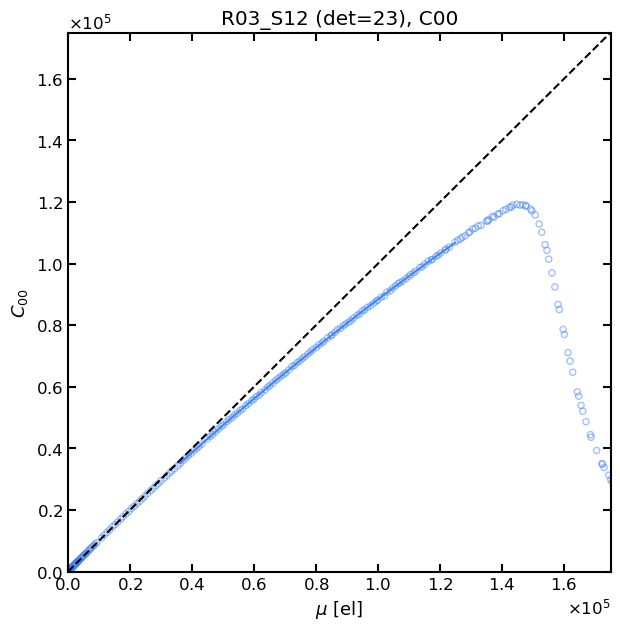

In [17]:
plt.scatter(mu*g,c00*g*g, marker="o", edgecolor="#4285F4", s=20,  facecolor="None", label="135211 (blue)", alpha=0.5)#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
plt.plot(mu[expIdMask]*g,c00_model[expIdMask]*g*g, "o-", ms=0, c="#4285F4")#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
plt.plot([0,1.75e5],[0,1.75e5], "k--")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(0,1.75e5)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}$")

## 3.0 Plotting $\Delta C_{00}/ C_{00}$

Text(0, 0.5, '$\\Delta C_{00} / C_{00}$')

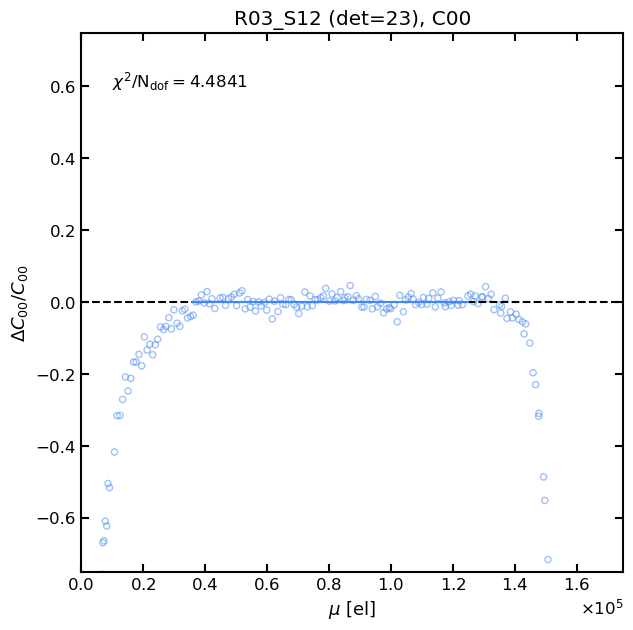

In [22]:
plt.axhline(0.0, linestyle="--", color="k")

plt.scatter(mu*g,(c00*g*g - c00_model*g*g)/c00_model*g*g, 
            marker="o", edgecolor="#4285F4", 
            s=20,  facecolor="None", 
            label="135211 (blue)", alpha=0.5)

plt.plot(mu[expIdMask]*g,
         (c00_model[expIdMask]*g*g - c00_model[expIdMask]*g*g)/c00_model[expIdMask]*g*g,
         "o-", ms=0, c="#4285F4")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.ylim(-0.75,0.75)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.text(.1e5,.6,r"$\chi^2 / \mathrm{N_{dof}} =$" + str(round(chi2_ndof(ptc,AMP)[0][0],4)))
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$\Delta C_{00} / C_{00}$")

## 4.0 Plotting $\tilde{C}_{00}/ \mu^2$

Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

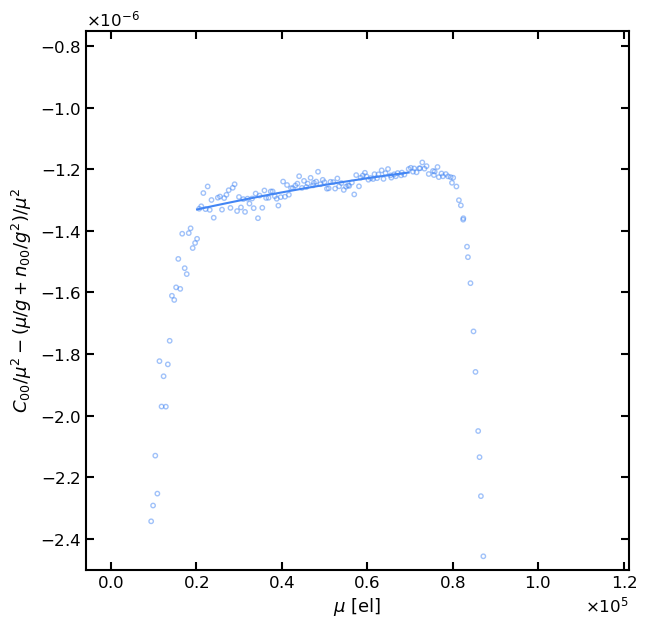

In [23]:
plt.scatter(mu,r, marker="o", edgecolor="#4285F4", s=10,  facecolor="None", label="135211 (blue)", alpha=0.5)
plt.plot(mu[expIdMask],r_model[expIdMask], "o-", ms=0, c="#4285F4")
#plt.axhline(a[0,0], linestyle="--", color="k")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-2.5e-6,-.75e-6)
#plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
#plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

In [11]:
import matplotlib.gridspec as gridspec

camera = LsstCam().getCamera()
detector = camera.get(sensor)

def avg_dict(d, exclude_channels=[]):

        t = np.zeros((8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())

def avg_dict2(d, exclude_channels=[]):

        t = np.zeros((338,8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())


gains = []
for l, channel in enumerate(camera[0].getAmplifiers()):
    #print(l,channel.getName())
    gains.append(ptc.gain[channel.getName()])

fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1], hspace=0.3*.5)
sub_fig = fig.subfigures(3, 3)
for i in range(3):
    for j in range(3): # 00->20 01->10
        ax1 = sub_fig[2-j][i].add_subplot(gs[0])
        ax2 = sub_fig[2-j][i].add_subplot(gs[1])
        l = 0
        mask = np.asarray(ptc.expIdMask[amp])
        n  = ptc.noiseMatrix[amp]
        g  = ptc.gain[amp] 
        mu = np.asarray(ptc.rawMeans[amp])
        C  = np.asarray(ptc.covariances[amp])[:,i,j]
        C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
        if i==0 and j==0 and l==0:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.plot(mu[mask]*g, (C_model[mask] / mu[mask]**2) - (mu[mask]/g + n[0][0]/g**2)/(mu[mask]**2), "-", color='k')
            #residual = ((C[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2) - ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2))) / ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2)) 
            #ax2.scatter(mu[mask]*g, residual, s=2, color='#4c8bf5', alpha=0.25)
            ax2.set_ylim(-0.2,0.2)
            ax2.set_xlim(0,2.0e5)
            #ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax1.set_ylim(-3.5e-6,0.0e-6)
            #ax1.set_title(r"$a_{00} = \frac{1}{\mu^2}\left [ C_{00} - \left ( \frac{\mu}{g} + \frac{n_{00}}{g^2}\right ) \right ]$")
            ax1.set_title(f'({i},{j})'.format(i,j))
        elif i==0 and j==0:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7, edgecolor="k", facecolor="None", alpha=0.5)
        elif i==2 and j==2 and l==0:
            ax1.scatter(mu*g,  C / mu**2 - (n[i][j]/g**2)/mu**2 , s=7,edgecolor="k", facecolor="None", alpha=0.5, label="Data (Run 5 EO tests)")
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        else:

            ax1.scatter(mu*g,  C / mu**2  - (n[i][j]/g**2)/mu**2, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        
        #

        if i==0 and j==0:

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            res1 = ((C / mu**2) - (mu/g + n[0][0]/g**2))
            res2 = ((C_model / mu**2) - (mu/g + n[0][0]/g**2))
            residual = (C - C_model) / C_model
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)

            ax2.set_xlim(0,2.0e5)
            ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax2.set_xlabel("Signal [el]")
        else:
            ax1.plot(mu[mask] * np.mean(gains),C_model[mask] / mu[mask]**2 - (n[i][j]/g**2)/mu[mask]**2 , "-", color='k', label="Astier+19 Eqn. 20 model")

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            residual = ((C / mu**2) - (C_model / mu**2)) / (C_model / mu**2)
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax2.set_ylim(-1,1)
            ax2.set_xlim(0,2.0e5)
                
        if 2-j==0 or i==2:
            ax2.set_ylim(-3.0,3.0)
            ax2.set_yticks([-3.0,3.0])
            pass
        
        
        ax1.axhline(ptc.aMatrix[amp][i][j], color="#4c8bf5", linewidth=1, linestyle="-", label=r"$a_{\,i\,j}$")

        ax1.set_xlim(0,2.0e5)
        ax2.set_xlabel("Signal [el]", labelpad=-0.25)
        ax2.set_ylabel(r"$\Delta C_{\,i\,j}\:/\:C_{\,i\,j}^{\,MODEL}$", labelpad=0)
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        #ax1.xaxis.major.formatter._useMathText = True
        ax1.yaxis.major.formatter._useMathText = True
        
        # ax1.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", label="pCTI turnoff", alpha=0.5)
        # ax2.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", alpha=0.5)
        # ax1.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", label="PTC turnoff", alpha=0.5)
        # ax2.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", alpha=0.5)
        # ax1.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", label="sCTI turnoff", alpha=0.5)
        # ax2.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", alpha=0.5)
        
        ax2.axhline(0.0, linestyle="-", linewidth=0.5, color="k", alpha=0.5)
        
        if i==0 and j==0:
            ax2.axhline(0.0, linestyle="--", linewidth=0.5, color="k", alpha=0.5)
            ax2.set_ylim(-0.010,0.010)
            ax2.set_yticks([-0.01,0.01])
        #elif 2-j==1 and i==0:
        #    ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        if i==2 and j==2:
            ax1.legend(frameon=True, ncol=1,fontsize=10, loc=1)
        plt.setp( ax1.get_xticklabels(), visible=False)
        ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)
        #ax1.set_title(f"$a_{{\:{i}\:{j}}}$")
        #ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
        ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        

#axs[0][1].set_title(r'$a_{01}$')
#axs[0][2].set_title(r'$a_{02}$')
#axs[1][0].set_title(r'$a_{10}$')
#axs[2][0].set_title(r'$a_{20}$')
#axs[1][1].set_title(r'$a_{11}$')
#axs[2][2].set_title(r'$a_{22}$')
#axs[2][1].set_title(r'$a_{21}$')
#axs[1][2].set_title(r'$a_{12}$')
#axs[2][0].set_xlabel("Signal [el]")
#axs[2][1].set_xlabel("Signal [el]")
#axs[2][2].set_xlabel("Signal [el]")


NameError: name 'sensor' is not defined

## 5.0 PTC Comparison

Compare PTC1 with PTC2


In [154]:
det = 23
AMP = "C00"
ptc0 = butlermain.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/BF/2023.10.09/ptc.R03-S12.trunc_to_pcti')


mu0, g0, expIdMask0, c000, c00_model0, n0, a0, r0, r_model0, r_mat0 = getPTCData(ptc0, AMP)

In [171]:
# Pick detectors
det = 128 # Interesting: 105
AMP = 'C14'

ptc1 =  butler.get('ptc', detector=det, instrument='LSSTCam', 
                   collections='u/lsstccs/ptc_13557_w_2023_41')
mu1, g1, expIdMask1, c001, c00_model1, n1, a1, r1, r_model1, r_mat1 = getPTCData(ptc1, AMP)

ptc2 =  butler.get('ptc', detector=det, instrument='LSSTCam', 
                   collections='u/lsstccs/ptc_13557_w_2023_49')
mu2, g2, expIdMask2, c002, c00_model2, n2, a2, r2, r_model2, r_mat2 = getPTCData(ptc2, AMP)



-0.0032448320416733623


In [155]:
# Optionally:
AMP = "C00"
mu1, g1, expIdMask1, c001, c00_model1, n1, a1, r1, r_model1, r_mat1 = getPTCDataFromFits("/sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.test.1/20231211T225747Z/ptc/ptc_LSSTCam_R03_S12_u_abrought_ptc_13511_test_1_20231211T225747Z.fits", AMP)
mu2, g2, expIdMask2, c002, c00_model2, n2, a2, r2, r_model2, r_mat2 = getPTCDataFromFits("/sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.test.3/20231211T225927Z/ptc/ptc_LSSTCam_R03_S12_u_abrought_ptc_13511_test_3_20231211T225927Z.fits", AMP)
mu3, g3, expIdMask3, c003, c00_model3, n3, a3, r3, r_model3, r_mat3 = getPTCDataFromFits("/sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.test.2/20231212T073918Z/ptc/ptc_LSSTCam_R03_S12_u_abrought_ptc_13511_test_2_20231212T073918Z.fits", AMP)
mu4, g4, expIdMask4, c004, c00_model4, n4, a4, r4, r_model4, r_mat4 = getPTCDataFromFits("/sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.test.4/20231212T074825Z/ptc/ptc_LSSTCam_R03_S12_u_abrought_ptc_13511_test_4_20231212T074825Z.fits", AMP)
mu5, g5, expIdMask5, c005, c00_model5, n5, a5, r5, r_model5, r_mat5 = getPTCDataFromFits("/sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.test.5/20231212T180152Z/ptc/ptc_LSSTCam_R03_S12_u_abrought_ptc_13511_test_5_20231212T180152Z.fits", AMP)
mu6, g6, expIdMask6, c006, c00_model6, n6, a6, r6, r_model6, r_mat6 = getPTCDataFromFits("/sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.test.7/20231214T025611Z/ptc/ptc_LSSTCam_R03_S12_u_abrought_ptc_13511_test_7_20231214T025611Z.fits", AMP)



In [7]:
a001, gain1, noisesqd1 = ptc1.ptcFitPars[AMP][0], ptc1.ptcFitPars[AMP][1], ptc1.ptcFitPars[AMP][2] # a00, gain, noise^2
c00_exp_model1 = []
for m in mu1:
    c00_exp_model1.append(astier19_eqn16(m, a001, gain1, noisesqd1))
    
a002, gain2, noisesqd2 = ptc2.ptcFitPars[AMP][0], ptc2.ptcFitPars[AMP][1], ptc2.ptcFitPars[AMP][2] # a00, gain, noise^2
c00_exp_model2 = []
for m in mu2:
    c00_exp_model2.append(astier19_eqn16(m, a002, gain2, noisesqd2))

c00_exp_model1 = np.array(c00_exp_model1)
c00_exp_model2 = np.array(c00_exp_model2)

r_exp_model1 = (c00_exp_model1 / mu1**2) - (mu1/g1 + n1/g1**2)/(mu1**2)
r_exp_model2 = (c00_exp_model2 / mu2**2) - (mu2/g2 + n2/g2**2)/(mu2**2)

NameError: name 'ptc1' is not defined

### 6.0 Early results

Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

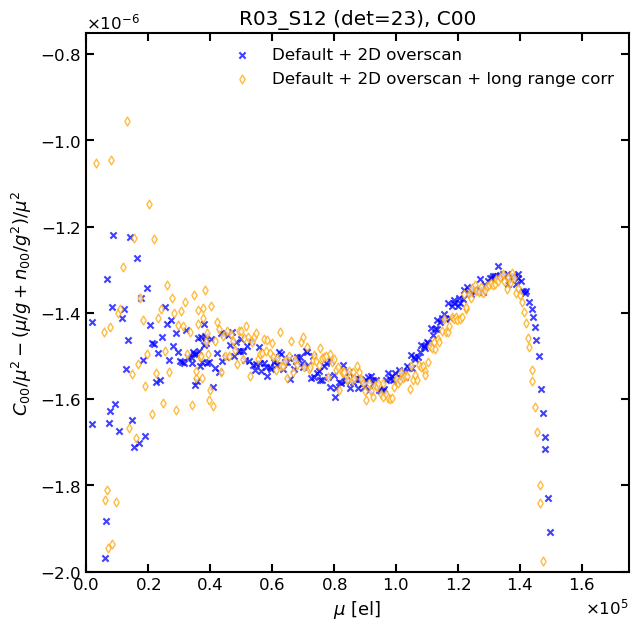

In [27]:
plt.scatter(mu2*g2, r2, marker="x", s=20,facecolor="b",color="b",alpha=.75, label="Default + 2D overscan")# facecolor="w",edgecolor="r")
plt.scatter(mu1*g1, r1, marker="d", s=20,facecolor="w", color="orange", alpha=.75, label="Default + 2D overscan + long range corr")# facecolor="w",edgecolor="r")


plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-2.0e-6,-.75e-6)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(frameon=False)
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

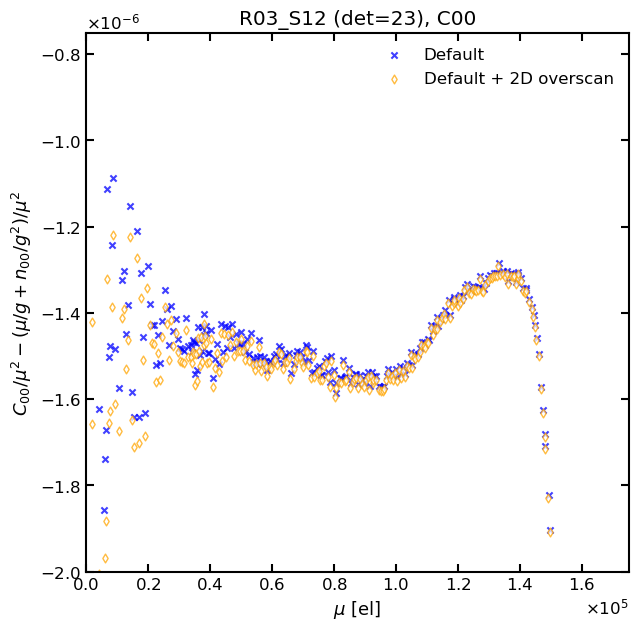

In [25]:
plt.scatter(mu1*g1, r1, marker="x", s=20,facecolor="b", color="b", alpha=.75, label="Default")# facecolor="w",edgecolor="r")
plt.scatter(mu2*g2, r2, marker="d", s=20,facecolor="w",color="orange",alpha=.75, label="Default + 2D overscan")# facecolor="w",edgecolor="r")


plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-2.0e-6,-.75e-6)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(frameon=False)
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

## PTC (Run 13511)
**Goal**: Derive a fully corrected PTC incl. new DM fixes


**Purpose**: Test quality, reliability, and self-consistency of DM, review new DM fixes

**Included fixes**:
1. Newly recommended 2D overscan correction
2. Improved NL correction (increased to 25 spline knots)
3. Improved CTI correction (DM-41754, DM-41911)
4. Improved PTC fitting range (DM-38989)
5. Long range correlation correction (DM-41681)

Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

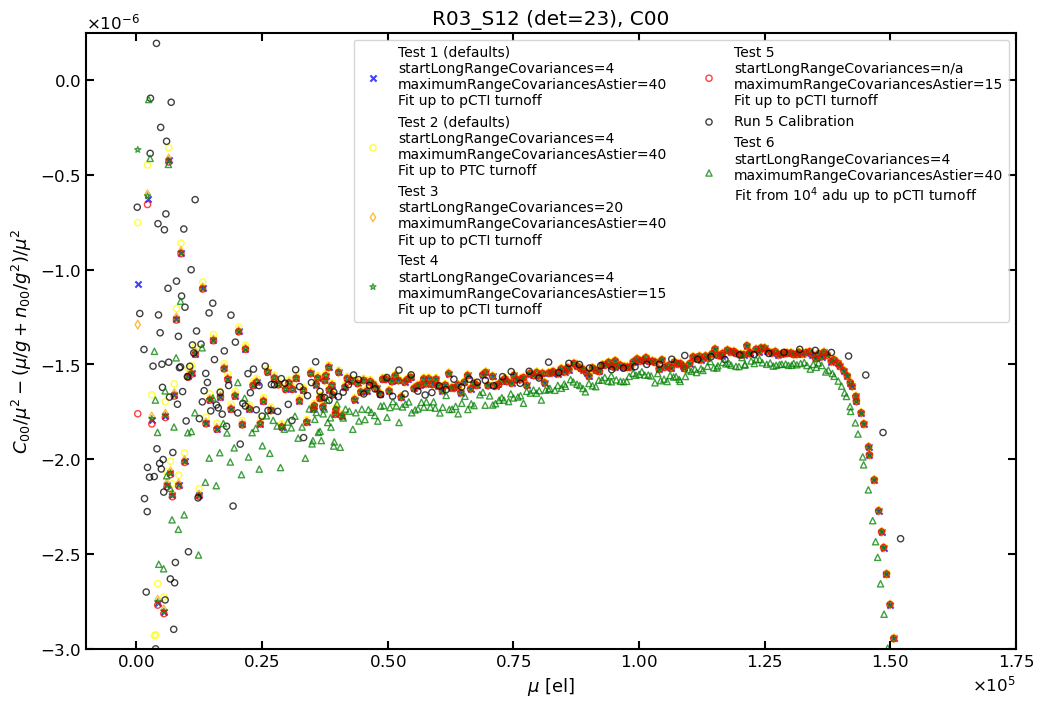

In [159]:
plt.figure(figsize=(12,8))
plt.scatter(mu1*g1, r1, marker="x", s=20,facecolor="b", color="b", alpha=.75, label="Test 1 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff")# facecolor="w",edgecolor="r")
plt.scatter(mu5*g5, r5, marker="o", s=20,facecolor="None",color="yellow",alpha=.75, label="Test 2 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to PTC turnoff")# facecolor="w",edgecolor="r")
plt.scatter(mu2*g2, r2, marker="d", s=20,facecolor="None",color="orange",alpha=.75, label="Test 3\nstartLongRangeCovariances=20\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff")# facecolor="w",edgecolor="r")
plt.scatter(mu4*g4, r4, marker="*", s=20,facecolor="None",color="green",alpha=.75, label="Test 4\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff")# facecolor="w",edgecolor="r")
plt.scatter(mu3*g3, r3, marker="o", s=20,facecolor="None",color="red",alpha=.75, label="Test 5\nstartLongRangeCovariances=n/a\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff")# facecolor="w",edgecolor="r")
plt.scatter(mu0*g0, r0, marker="o", s=20,facecolor="None",color="k",alpha=.75, label="Run 5 Calibration")# facecolor="w",edgecolor="r")
plt.scatter(mu6*g6, r6, marker="^", s=20,facecolor="None",color="green",alpha=.75, label="Test 6\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit from $10^4$ adu up to pCTI turnoff")# facecolor="w",edgecolor="r")


plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-3e-6,.25e-6)
plt.xlim(-1e4,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(loc=1,ncol=2,frameon=True, fontsize=10)
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

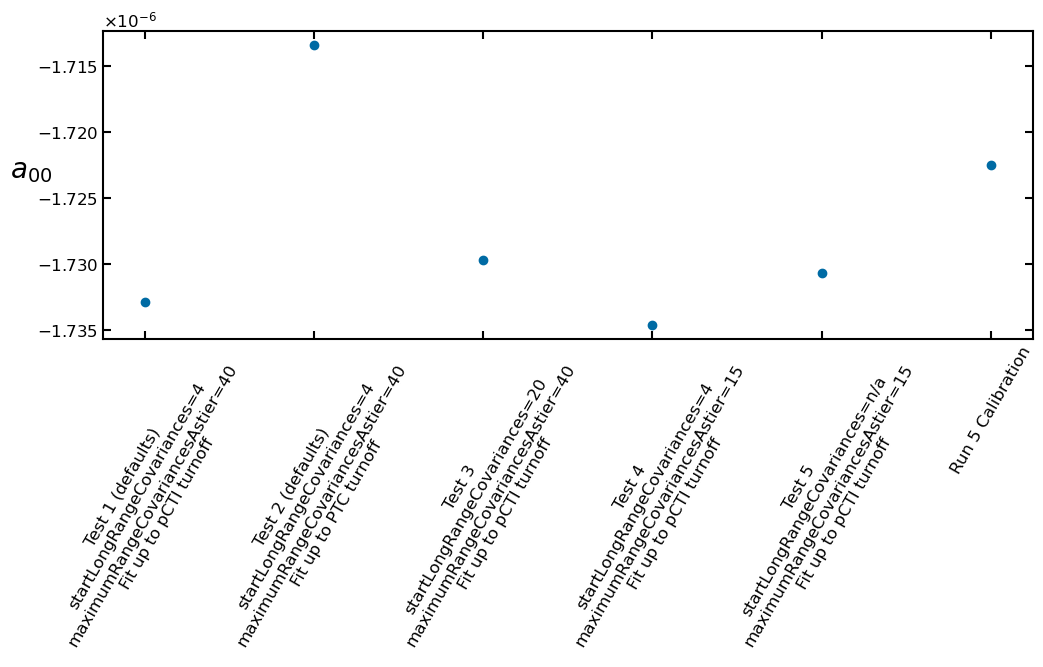

In [82]:
plt.figure(figsize=(12,4))
plt.scatter(range(6),[a1, a5, a2, a4, a3,a0[0][0]])
_ = plt.xticks(range(6), labels=["Test 1 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff",
                                 "Test 2 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to PTC turnoff",
                                 "Test 3\nstartLongRangeCovariances=20\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff",
                                 "Test 4\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff",
                                 "Test 5\nstartLongRangeCovariances=n/a\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff",
                                 "Run 5 Calibration"], rotation=60)
plt.ylabel("$a_{00}$", fontsize=20,rotation=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

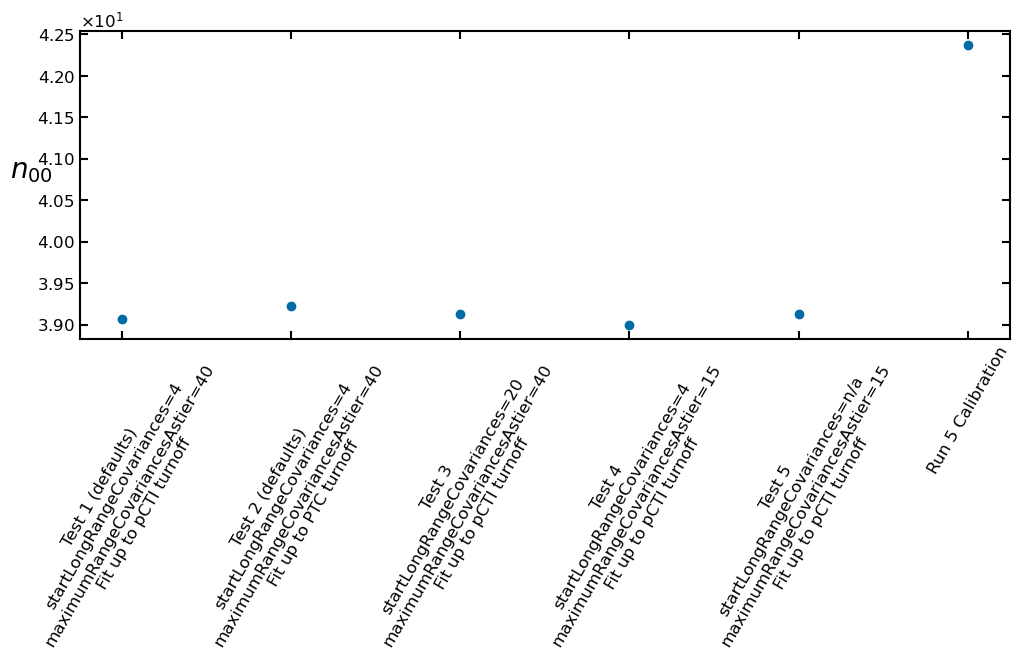

In [87]:
plt.figure(figsize=(12,4))
plt.scatter(range(6),[n1, n5, n2, n4, n3,n0])
_ = plt.xticks(range(6), labels=["Test 1 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff",
                                 "Test 2 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to PTC turnoff",
                                 "Test 3\nstartLongRangeCovariances=20\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff",
                                 "Test 4\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff",
                                 "Test 5\nstartLongRangeCovariances=n/a\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff",
                                 "Run 5 Calibration"], rotation=60)
plt.ylabel("$n_{00}$", fontsize=20,rotation=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

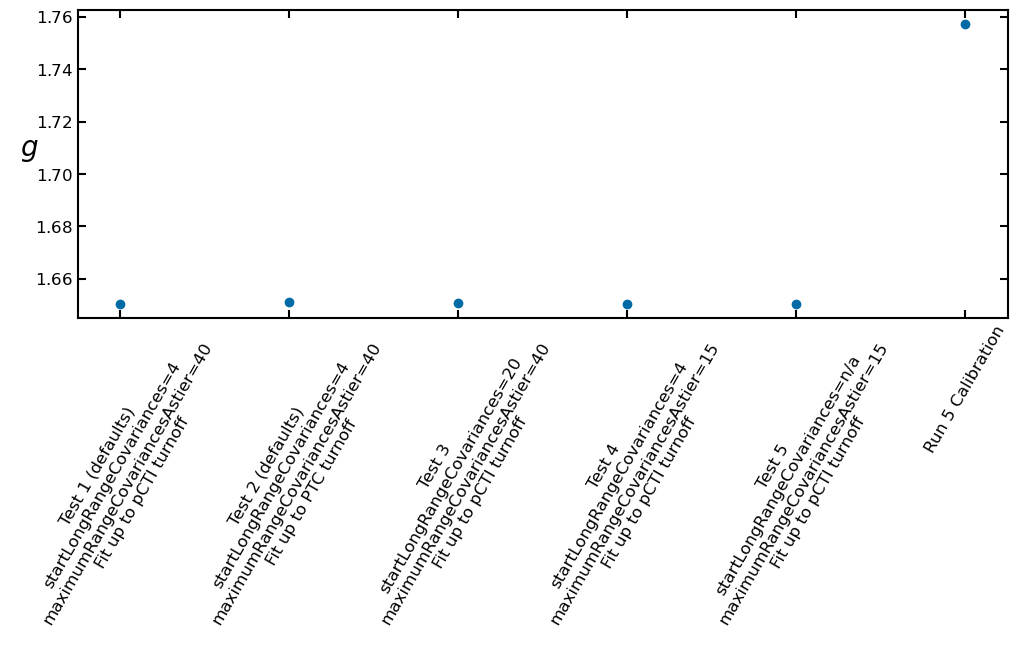

In [88]:
plt.figure(figsize=(12,4))
plt.scatter(range(6),[g1, g5, g2, g4, g3,g0])
_ = plt.xticks(range(6), labels=["Test 1 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff",
                                 "Test 2 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40\nFit up to PTC turnoff",
                                 "Test 3\nstartLongRangeCovariances=20\nmaximumRangeCovariancesAstier=40\nFit up to pCTI turnoff",
                                 "Test 4\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff",
                                 "Test 5\nstartLongRangeCovariances=n/a\nmaximumRangeCovariancesAstier=15\nFit up to pCTI turnoff",
                                 "Run 5 Calibration"], rotation=60)
plt.ylabel("$g$", fontsize=20,rotation=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

## Comparison of fit ranges

In [5]:
AMP='C00'
ptc0 =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13539')
mu0, g0, expIdMask0, c000, c00_model0, n0, a0, r0, r_model0, r_mat0 = getPTCData(ptc0, AMP)


ptc1 =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13538.v2')
mu1, g1, expIdMask1, c001, c00_model1, n1, a1, r1, r_model1, r_mat1 = getPTCData(ptc1, AMP)


In [6]:
ptc3 =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13538.v3')
mu3, g3, expIdMask3, c003, c00_model3, n3, a3, r3, r_model3, r_mat3 = getPTCData(ptc3, AMP)

In [7]:
ptc4 =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13538.v4')
mu4, g4, expIdMask4, c004, c00_model4, n4, a4, r4, r_model4, r_mat4 = getPTCData(ptc4, AMP)

ptc5 =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13538.v5')
mu5, g5, expIdMask5, c005, c00_model5, n5, a5, r5, r_model5, r_mat5 = getPTCData(ptc5, AMP)

In [8]:
ptc6 =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13538.v6')
mu6, g6, expIdMask6, c006, c00_model6, n6, a6, r6, r_model6, r_mat6 = getPTCData(ptc6, AMP)

Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

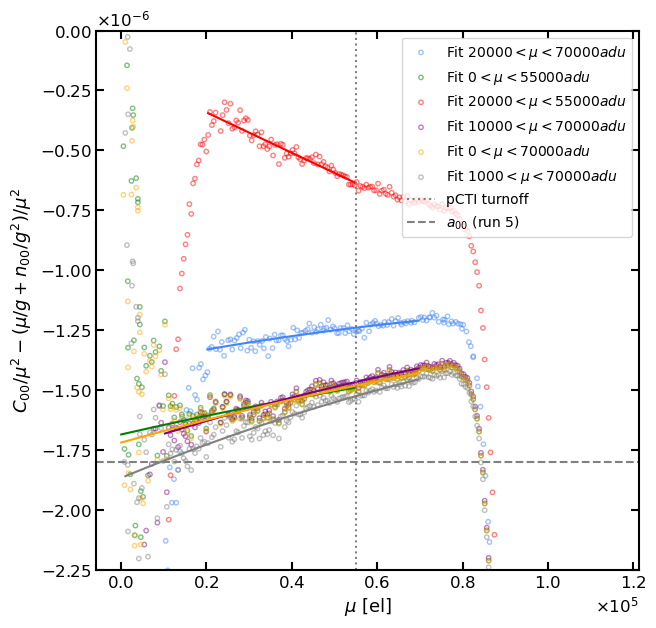

In [9]:
plt.scatter(mu0, r0, marker="o", edgecolor="#4285F4", s=10,  facecolor="None", label="Fit $20000<\mu<70000adu$", alpha=0.5)
plt.plot(mu0[expIdMask0],r_model0[expIdMask0], "o-", ms=0, c="#4285F4")

plt.scatter(mu1, r1, marker="o", edgecolor="green", s=10,  facecolor="None", label="Fit $0<\mu<55000adu$", alpha=0.5)
plt.plot(mu1[expIdMask1],r_model1[expIdMask1], "o-", ms=0, c="green")

plt.scatter(mu3, r3, marker="o", edgecolor="red", s=10,  facecolor="None", label="Fit $20000<\mu<55000adu$", alpha=0.5)
plt.plot(mu3[expIdMask3],r_model3[expIdMask3], "o-", ms=0, c="red")

plt.scatter(mu4, r4, marker="o", edgecolor="purple", s=10,  facecolor="None", label="Fit $10000<\mu<70000adu$", alpha=0.5)
plt.plot(mu4[expIdMask4],r_model4[expIdMask4], "o-", ms=0, c="purple")

plt.scatter(mu5, r5, marker="o", edgecolor="orange", s=10,  facecolor="None", label="Fit $0<\mu<70000adu$", alpha=0.5)
plt.plot(mu5[expIdMask5],r_model5[expIdMask5], "o-", ms=0, c="orange")

plt.scatter(mu6, r6, marker="o", edgecolor="gray", s=10,  facecolor="None", label="Fit $1000<\mu<70000adu$", alpha=0.5)
plt.plot(mu6[expIdMask6],r_model6[expIdMask6], "o-", ms=0, c="gray")

plt.axvline(55000., linestyle=":", color="gray", label="pCTI turnoff")
plt.axhline(-1.8e-6, linestyle="--", color="gray", label="$a_{00}$ (run 5)")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-2.25e-6,-1e-6)
plt.ylim(-2.25e-6,0e-6)
#plt.xlim(1e4,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(fontsize=10)
#plt.xscale("log")
#plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

In [10]:
labels = [
    "Fit 20000<µ<70000adu",
    "Fit 0<µ<55000adu",
    "Fit 20000<µ<55000adu",
    "Fit 10000<µ<70000adu",
    "Fit 0<µ<70000adu",
    "Fit 1000<µ<70000adu"
]
print(f"R03-S12, {AMP}\n")
for i,ptc in enumerate([ptc0,ptc1,ptc3,ptc4,ptc5,ptc6]):
    print(f"{labels[i]:30}", f"NOISE = {ptc.noiseMatrix['C00'][0][0]:20}", "  GAIN =", ptc.gain['C00'])

R03-S12, C00

Fit 20000<µ<70000adu           NOISE =     763.970733248518   GAIN = 1.7899530819297174
Fit 0<µ<55000adu               NOISE =   40.449778531144716   GAIN = 1.7452110428159755
Fit 20000<µ<55000adu           NOISE =   2830.3293602867125   GAIN = 1.948436103990203
Fit 10000<µ<70000adu           NOISE =   137.95363667016875   GAIN = 1.7493005962058514
Fit 0<µ<70000adu               NOISE =    40.37510605386431   GAIN = 1.7447676746550838
Fit 1000<µ<70000adu            NOISE =    34.13720039691468   GAIN = 1.7377417875347512


Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

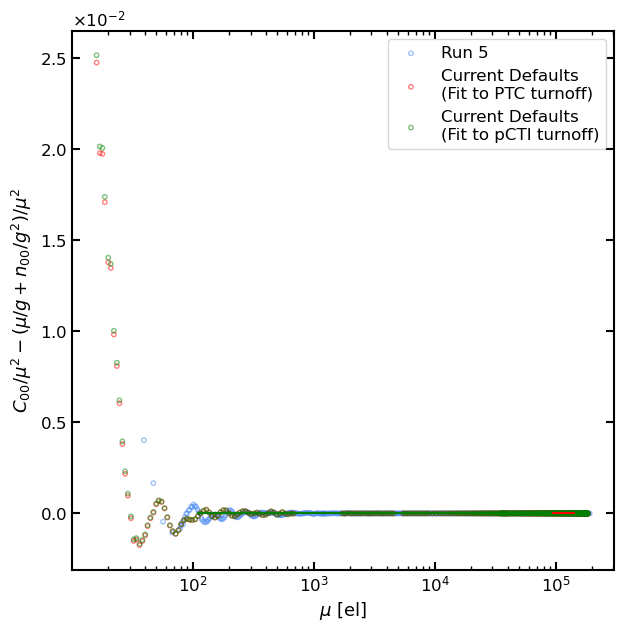

In [92]:
plt.scatter(mu0*g0, r0, marker="o", edgecolor="#4285F4", s=10,  facecolor="None", label="Run 5", alpha=0.5)
plt.plot(mu0[expIdMask0]*g0,r_model0[expIdMask0], "o-", ms=0, c="#4285F4")

plt.scatter(mu5*g5, r5, marker="o", edgecolor="red", s=10,  facecolor="None", label="Current Defaults\n(Fit to PTC turnoff)", alpha=0.5)
plt.plot(mu5[expIdMask5]*g5,r_model5[expIdMask5], "o-", ms=0, c="red")

plt.scatter(mu1*g1, r1, marker="o", edgecolor="green", s=10,  facecolor="None", label="Current Defaults\n(Fit to pCTI turnoff)", alpha=0.5)
plt.plot(mu1[expIdMask1]*g1,r_model1[expIdMask1], "o-", ms=0, c="green")

#plt.axhline(a[0,0], linestyle="--", color="k")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
#plt.ylim(-2.25e-6,-1e-6)
#plt.xlim(1e4,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend()
plt.xscale("log")
#plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

In [12]:



refs=list(registry.queryDatasets('postISRCCD', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13538'))
print(len(refs))
#ptc6 =  butler.get('postISRCCD', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.12.14.2023.run-13538.v6')






0


Text(0, 0.5, '$C_{01}/\\mu^2 - (n_{01}/g^{2})/\\mu^2$')

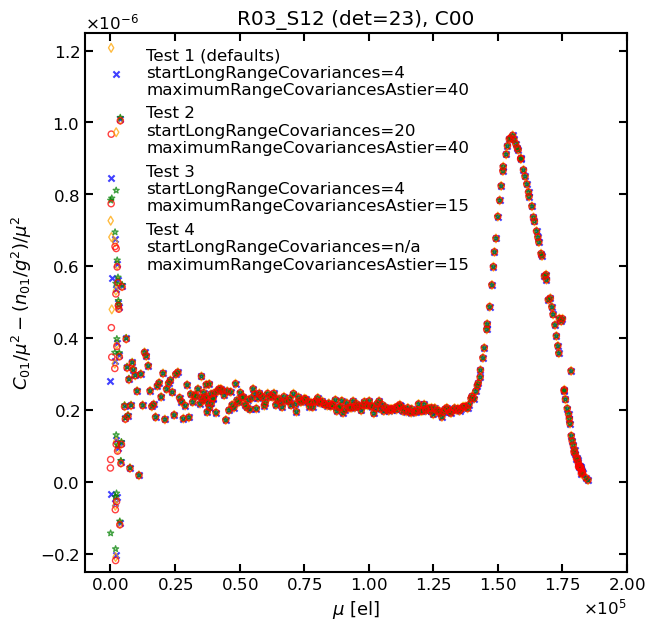

In [71]:
plt.scatter(mu1*g1, r_mat1[:,0,1], marker="x", s=20,facecolor="b", color="b", alpha=.75, label="Test 1 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40")# facecolor="w",edgecolor="r")
plt.scatter(mu2*g2, r_mat2[:,0,1], marker="d", s=20,facecolor="None",color="orange",alpha=.75, label="Test 2\nstartLongRangeCovariances=20\nmaximumRangeCovariancesAstier=40")# facecolor="w",edgecolor="r")
plt.scatter(mu4*g4, r_mat4[:,0,1], marker="*", s=20,facecolor="None",color="green",alpha=.75, label="Test 3\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=15")# facecolor="w",edgecolor="r")
plt.scatter(mu3*g3, r_mat3[:,0,1], marker="o", s=20,facecolor="None",color="red",alpha=.75, label="Test 4\nstartLongRangeCovariances=n/a\nmaximumRangeCovariancesAstier=15")# facecolor="w",edgecolor="r")


plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-.25e-6,1.25e-6)
plt.xlim(-1e4,2.0e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(frameon=False)
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{01}/\mu^2 - (n_{01}/g^{2})/\mu^2$")

Text(0, 0.5, '$C_{10}/\\mu^2 - (n_{10}/g^{2})/\\mu^2$')

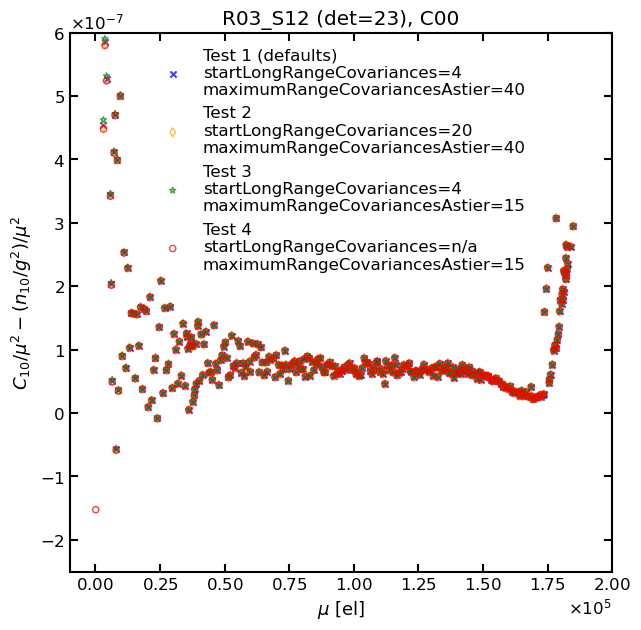

In [43]:
plt.scatter(mu1*g1, r_mat1[:,1,0], marker="x", s=20,facecolor="b", color="b", alpha=.75, label="Test 1 (defaults)\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=40")# facecolor="w",edgecolor="r")
plt.scatter(mu2*g2, r_mat2[:,1,0], marker="d", s=20,facecolor="None",color="orange",alpha=.75, label="Test 2\nstartLongRangeCovariances=20\nmaximumRangeCovariancesAstier=40")# facecolor="w",edgecolor="r")
plt.scatter(mu4*g4, r_mat4[:,1,0], marker="*", s=20,facecolor="None",color="green",alpha=.75, label="Test 3\nstartLongRangeCovariances=4\nmaximumRangeCovariancesAstier=15")# facecolor="w",edgecolor="r")
plt.scatter(mu3*g3, r_mat3[:,1,0], marker="o", s=20,facecolor="None",color="red",alpha=.75, label="Test 4\nstartLongRangeCovariances=n/a\nmaximumRangeCovariancesAstier=15")# facecolor="w",edgecolor="r")


plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-.25e-6,0.6e-6)
plt.xlim(-1e4,2.0e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(frameon=False)
plt.title(f"{det} (det={det_name}), {AMP}")
plt.ylabel("$C_{10}/\mu^2 - (n_{10}/g^{2})/\mu^2$")

## 7.0 Summed $\widetilde{C}_{ij}/\mu^2$

In [84]:
r_mat1.shape
maxN = 10
result = np.zeros((r_mat1.shape[0], len(range(1,maxN))))
for i in range(len(mu1)):
    sums = []
    for j in range(1,maxN):
        sums.append(np.sum(tileArray(r_mat1[i][:j,:j])))
    result[i] = np.array(sums)
result = result.T

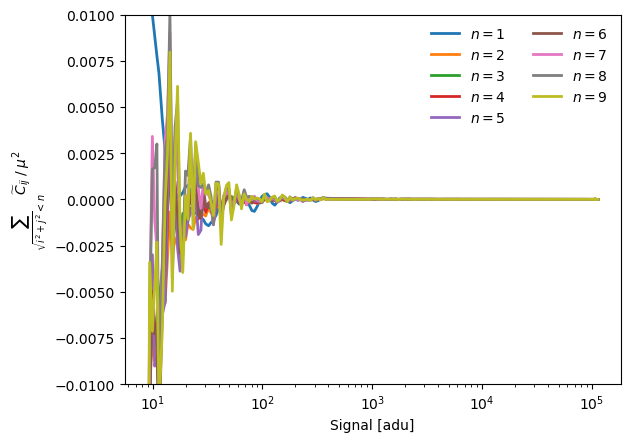

In [98]:
plt.style.use('default')
for i in range(result.shape[0]):
    plt.plot(mu1,result[i], label="$n=$" + str(i+1), linewidth=2)
plt.xscale('log')
plt.ylabel("$\sum_{\sqrt{i^2 + j^2} < n} \widetilde{C}_{ij}\;/\;\mu^2$")
plt.xlabel('Signal [adu]')
plt.ylim(-.01,.01)
plt.legend(loc=1,ncol=2, frameon=False)

## 7.0 Summed Covariances

C10 1.6551045870102052
C11 1.6777522580324358
C12 1.6742311569896453
C13 1.6782840093076583
C14 1.6673941032005637
C15 1.673097556812531
C16 1.6694742071782145
C17 1.6514928653020713
C07 1.590661380231778
C06 1.7326242429088319
C05 1.754343492800474
C04 1.7362217405779004
C03 1.7423502505132833
C02 1.7315412021887482
C01 1.7542163286552281
C00 1.7492596918335255


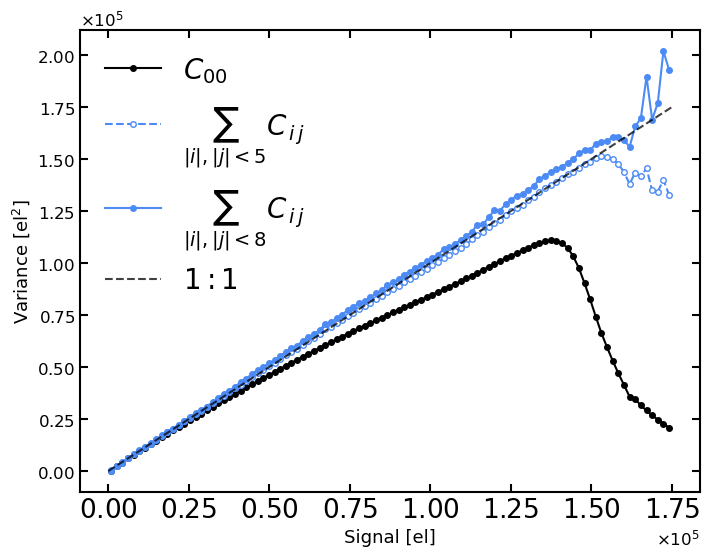

In [39]:
ptc =  butler.get('ptc', detector=23, instrument='LSSTCam', collections='u/abrought/ptc.13511.basic.doLinearizeFalse')

gains = []

fig = plt.figure(figsize=(8,6), facecolor="w")
from matplotlib.pyplot import cm
color = cm.tab20(np.linspace(0, 1, 16))
bins = []
means = np.zeros((16,100))
means_4x4 = np.zeros((16,100))
means_full = np.zeros((16,100))
for i, amp in enumerate(camera[0].getAmplifiers()):
    print(amp.getName(), ptc.gain[amp.getName()])
    gains.append(ptc.gain[amp.getName()])

    mask = ptc.expIdMask[amp.getName()]
    flux = np.asarray(ptc.rawMeans[amp.getName()]) * ptc.gain[amp.getName()]
    C    = np.asarray(ptc.rawVars[amp.getName()]) * ptc.gain[amp.getName()] * ptc.gain[amp.getName()]
    
    _bins, _means = bin_along_x(flux, C, 100, range_x=(0,1.75e5))
    #print(_means)
    bins = _bins
    means[i]= _means
    
    summation_full = []
    summation_4x4 = []
    for j in range(len(flux)):
        cov = np.asarray(ptc.covariances[amp.getName()])[j] * ptc.gain[amp.getName()] * ptc.gain[amp.getName()]
        summation_full.append(np.sum(tileArray(cov[:8,:8])))
        summation_4x4.append(np.sum(tileArray(cov[:5,:5])))
    
    _bins, _means = bin_along_x(flux, np.asarray(summation_4x4), 100, range_x=(0,1.75e5)) 
    means_4x4[i] = _means
    _bins, _means = bin_along_x(flux, np.asarray(summation_full), 100, range_x=(0,1.75e5)) 
    means_full[i] = _means
    

means = np.nanmean(means, axis=0)
means_4x4 = np.nanmean(means_4x4, axis=0)
means_full = np.nanmean(means_full, axis=0)
plt.plot(bins, means, "o-", color="k", markersize=4,label=r"$C_{00}$")
plt.plot(bins, means_4x4, "o--", color="#4c8bf5", markerfacecolor="w",markersize=4, label=r"$\sum_{|i|,|j|<5}^{} C_{\,i\,j}$")
plt.plot(bins, means_full, "o-",color = "#4c8bf5", markersize=4, label=r"$\sum_{|i|,|j|<8}^{} C_{\,i\,j}$")


plt.plot(np.linspace(0.,175000., 10), 1. * np.linspace(0.,175000., 10), "k--", alpha=0.75, label=r"$1:1$")


#plt.title("PTC - R03-S12 - $C_{00}$ (BF Corrected, factor=0.775)")
plt.xlabel("Signal [el]")
plt.ylabel("Variance [el$^2$]")
plt.xticks(np.asarray([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75])*1e5, fontsize=19)
#plt.text(1.0e5,1.2e5,"$\overline{g}=$" + str(round(np.mean(gains), 3)) + " $e^-$/ADU", rotation=38)
plt.legend(loc='upper left',ncol=1,frameon=False, fontsize=20)

# Format with 2 decimal places
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)


In [34]:
ix = np.indices((15,15))
r=np.hypot(ix[0],ix[1])

/tmp/ipykernel_25059/3168951423.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-1,20)


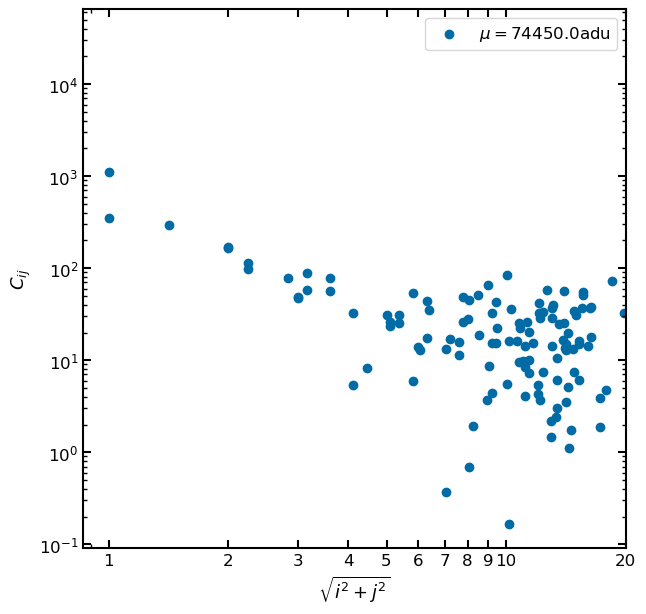

In [48]:
plt.scatter(r.ravel(),ptc.covariances['C00'][300].ravel(), label="$\mu = $" + str(round(ptc.rawMeans['C00'][300],-1)) + "adu")
plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,20)
_ = plt.xticks([1,2,3,4,5,6,7,8,9,10,20],
              labels=[str(_) for _ in [1,2,3,4,5,6,7,8,9,10,20]])
plt.ylabel("$C_{ij}$")
plt.xlabel("$\sqrt{i^2 + j^2}$")
plt.legend()

## 6.0 Quick check ISR impact on $\widetilde{C}_{00}/ \mu^2$ on single flat pair


In [14]:
raw1 = butler.get("raw", instrument="LSSTCam",detector=23,exposure=2023110500198, collections='LSSTCam/raw/all')
raw2 = butler.get("raw", instrument="LSSTCam",detector=23,exposure=2023110500199, collections='LSSTCam/raw/all')

bias = butler.get("bias", instrument="LSSTCam",detector=23, collections='u/lsstccs/bias_13505_w_2023_41/20231104T221805Z')
dark = butler.get("dark", instrument="LSSTCam",detector=23, collections='u/lsstccs/dark_13505_w_2023_41/20231104T222709Z')
#flat = butler.get("flat", instrument="LSSTCam",detector=23, physical_filter='ef_43',collections='u/lsstccs/flat_13505_w_2023_41/20231104T223548Z')
cti=butler.get('cpCtiCalib', instrument='LSSTCam', detector=23, collections='u/abrought/cti.2023.11.29.DM-41754_and_DM-41911')
defect = butler.get("defects", instrument="LSSTCam",detector=23, collections='u/lsstccs/defects_13505_w_2023_41/20231104T224625Z')
linearizer = butler.get("linearizer", instrument="LSSTCam",detector=23, collections='u/cslage/linearizer_28jan22/20220128T174703Z')

config = IsrTask.ConfigClass()
config.doDark = True
config.doBias = True
config.doFlat = False
config.doDefect = True
config.doOverscan = True
config.overscan.doParallelOverscan = True
config.overscan.fitType = "MEDIAN"
config.doLinearize=True
config.doDeferredCharge=True
config.doBrighterFatter=False
config.doApplyGains=False
isrtask = IsrTask(config=config) # default configuration
detector=23

print("Flat 1")
flat1 = isrtask.run(raw1, camera=LsstCam.getCamera(),
            deferredChargeCalib=cti,
            defects=defect,
            dark=dark,
            bias=bias,
            linearizer = linearizer,
            detectorNum=23)


Flat 1


  3.81559732e+04  4.66618013e+04  5.50788275e+04  6.35237786e+04
  7.23547623e+04  8.14810749e+04  3.81059820e+00 -1.50719013e+00
  1.03123736e+01  2.93004895e+01  5.04457103e+01  7.04954409e+01
  6.12702317e+01  1.44651745e+01 -5.60844687e+00  4.00735112e+01]) for C10
  3.64891914e+04  4.46322712e+04  5.26844358e+04  6.07528460e+04
  6.92029638e+04  7.79482682e+04  4.07595418e+00 -1.69245124e+00
  8.63750555e+00  2.72110218e+01  4.81850911e+01  7.56282402e+01
  8.39200631e+01  5.41990707e+01  1.79265131e+01  3.62317224e+01]) for C11
  3.56924305e+04  4.36585512e+04  5.15359580e+04  5.94302472e+04
  6.76883935e+04  7.62552154e+04  3.30369838e+00 -1.76156872e+00
  7.23225940e+00  2.45431297e+01  4.27178890e+01  6.93808687e+01
  8.14135900e+01  5.73293165e+01  1.58985351e+01  1.18355092e+01]) for C12
  3.62595348e+04  4.43511288e+04  5.23523824e+04  6.03697790e+04
  6.87664696e+04  7.74564806e+04  3.58127283e+00 -1.67790862e+00
  8.49301662e+00  2.67369224e+01  4.80438857e+01  7.75732047

In [19]:
print(flat1.exposure.getMetadata()['LSST READNOISE C00']**2)

38.081241000000006


In [58]:
mu_, varDiff_, covDiffAstier_ = getC(flat1,flat2)

[17019.514108933985] [-1.7882494980113459e-06]


Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

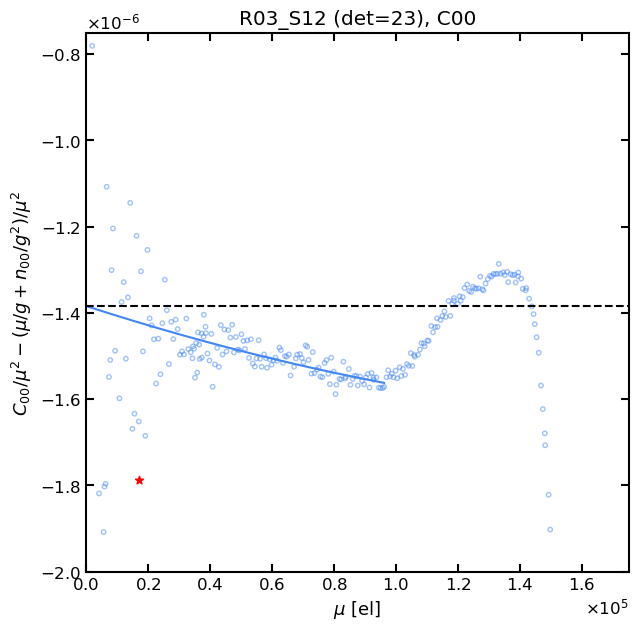

In [59]:
plt.scatter(mu*g,r, marker="o", edgecolor="#4285F4", s=10,  facecolor="None", label="135211 (blue)", alpha=0.5)
plt.plot(mu[expIdMask]*g,r_model[expIdMask], "o-", ms=0, c="#4285F4")
plt.axhline(a[0,0], linestyle="--", color="k")

r_ = (varDiff_ / mu_**2) - (mu_/g + n/g**2)/(mu_**2)
print([mu_*g], [-r_])
plt.scatter([mu_*g], [-r_], marker="*", color="r")# facecolor="w",edgecolor="r")


plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-2.0e-6,-.75e-6)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")